# K-Means from Scratch

In [75]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.random import sample_without_replacement

## Dataset

In [76]:
data_df = pd.read_csv('dataset/CSE575-HW03-Data.csv', header=None)
print('data shape: ', data_df.shape)
print('data type: ', data_df.dtypes)
data_df.head()

data shape:  (128, 13)
data type:  0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
dtype: object


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,92.9894,-9.6430,-4.6412,-6.8569,-5.2263,-4.9604,2.3191,-0.4579,0.5685,1.8047,2.6274,5.2223,6.5404
1,73.4054,6.5269,-6.6736,0.5054,-4.4818,-5.1157,-6.3784,1.6296,-3.3999,0.0652,-2.5042,1.7626,-1.0612
2,94.6334,-4.5986,-12.4970,-6.3137,-6.7072,-7.4690,-6.7463,-3.6960,-3.4587,-1.4178,-1.3265,1.8756,0.6391
3,89.1135,-2.2287,0.2304,-2.7300,-0.9133,-1.9530,-1.0086,0.1486,2.0624,1.1938,-1.0113,0.1567,-1.2346
4,76.1929,2.5222,9.1796,4.3947,6.6885,4.0074,1.9488,2.2791,-0.2567,2.8208,-2.9867,-3.6861,-2.2471


## Clean the Data (Missing Value)

In [77]:
data_df = data_df.fillna(data_df.mean())
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,92.9894,-9.6430,-4.6412,-6.8569,-5.2263,-4.9604,2.3191,-0.4579,0.5685,1.8047,2.6274,5.2223,6.5404
1,73.4054,6.5269,-6.6736,0.5054,-4.4818,-5.1157,-6.3784,1.6296,-3.3999,0.0652,-2.5042,1.7626,-1.0612
2,94.6334,-4.5986,-12.4970,-6.3137,-6.7072,-7.4690,-6.7463,-3.6960,-3.4587,-1.4178,-1.3265,1.8756,0.6391
3,89.1135,-2.2287,0.2304,-2.7300,-0.9133,-1.9530,-1.0086,0.1486,2.0624,1.1938,-1.0113,0.1567,-1.2346
4,76.1929,2.5222,9.1796,4.3947,6.6885,4.0074,1.9488,2.2791,-0.2567,2.8208,-2.9867,-3.6861,-2.2471


In [78]:
data_x = data_df.to_numpy()
print('dataset in numpy array with shape: ', data_x.shape)

dataset in numpy array with shape:  (128, 13)


## Implement K-Means

### Define the loss function

In [79]:
# Use L2-Norm
def dist_l2(x0, x1):
    return np.linalg.norm(x0-x1)

def loss_J(X, r, mu, dist_func=dist_l2):
    """
    X is the dataset
    r is the cluster assignment of each data point
    mu is the list of centroids
    """
    loss = 0
    for i, x in enumerate(X):
        cluster_id = r[i]
        mu_x = mu[cluster_id-1]
        loss += float(dist_func(mu_x, x)**2)
    return loss

### The k-means function

In [90]:
def do_k_means(x, k, mu=None, dist_func=dist_l2):
    """
    x is the dataset
    k is the number of centroids
    mu is the initial position of the centroids
    """
    n_x = len(x)

    # if mu is None, we will randomly initialize the centroids
    if mu is None:
        x_idx = sample_without_replacement(n_population=x.shape[0], n_samples=k)
        mu = x[x_idx]
    # the cluster assignment of each data point (0 means not assigned, cluster ids start from 1)
    r = np.zeros(shape=(n_x, ), dtype=np.uint8)

    iteration = 1
    is_converged = False
    while not is_converged:
        is_converged = True

        # Update the cluster assignments r for each data point x
        for i, x_i in enumerate(x):
            # find the closest cluster
            cluster_x = None
            min_r_dist = None
            # iterate through each mu
            for j, mu_j in enumerate(mu):
                cluster_id = j + 1
                dis2r = dist_func(x_i, mu_j)
                if min_r_dist is None or dis2r < min_r_dist:
                    min_r_dist = dis2r
                    cluster_x = cluster_id
            # assign x to cluster r_x
            if r[i] != cluster_x:
                r[i] = cluster_x
                is_converged = False

        # update mu by computing the mean of each cluster
        for i in range(0, k):
            n_cluster_i = 0    # count the data points in current cluster
            cluster_id = i + 1   # cluster id

            sum_cluster_i = 0 
            for j, r_x in enumerate(r):
                if r_x == cluster_id:
                    sum_cluster_i += x[j]
                    n_cluster_i += 1
            if n_cluster_i == 0:
                print('Warning: no data point assigned to cluster ', cluster_id, ', k is ', k)
            else:
                mu[i] = sum_cluster_i/n_cluster_i
        
        iteration += 1
        
    print('k: %d, converged after %d steps, loss J: %s' % (k, iteration, str(loss_J(x, r, mu))))
    return r, mu, loss_J(x, r, mu)

In [91]:
def run_evaluation(x, k_list):
    r_log = []
    mu_log = []
    loss_log = []
    for k in k_list:
        info = do_k_means(x, k)
        r_log.append(info[0])
        mu_log.append(info[1])
        loss_log.append(info[2])

    return r_log, mu_log, loss_log

k_list = [2, 3, 4, 5, 6, 7, 8, 9]
r_log, mu_log, loss_log = run_evaluation(data_x, k_list)

k: 2, converged after 5 steps, loss J: 17488.957285790137
k: 3, converged after 9 steps, loss J: 15273.467224297003
k: 4, converged after 10 steps, loss J: 12443.901246690439
k: 5, converged after 7 steps, loss J: 11964.430516156277
k: 6, converged after 13 steps, loss J: 11195.141792280878
k: 7, converged after 8 steps, loss J: 10215.7334697426
k: 8, converged after 7 steps, loss J: 9799.832754988069
k: 9, converged after 13 steps, loss J: 9387.858287544233


## Visualize the Result

### Plot the objective function as a function of k

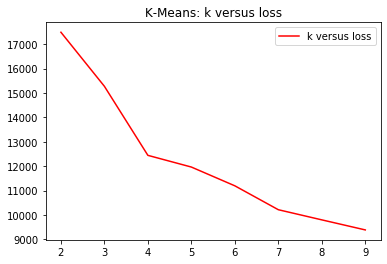

In [92]:
def plot_loss_versus_k(loss_list, k_list):
    plt.plot(k_list, loss_list, 'r', label='k versus loss')
    plt.legend()
    plt.title('K-Means: k versus loss')

plot_loss_versus_k(loss_log, k_list)

### For k = 2, plot the points using its first two features. Use two different colors or symbols to distinguish the two clusters

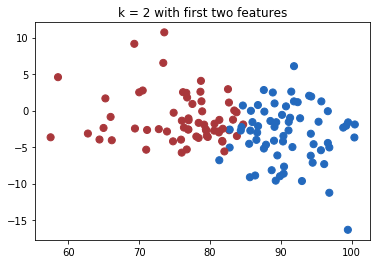

In [93]:
def plot_two_features(data, r):
    plt.scatter(data[:, 0], data[:, 1], c=r, s=50, cmap='vlag')
    plt.title('k = 2 with first two features')

plot_two_features(data_x, r_log[0])